# Определение перспективного тарифа для телеком-компании

## Описание проекта

### Цель исследования

Из двух предложенных тарифов ("Смарт" и "Ультра") выбрать наиболее перспективный (потенциально приносящий большую прибыль) для дальнейшей коррекции рекламного бюджета коммерческим отделом.

### Источник данных

Данные выборки из 500 клиентов за 2018 год (персональные данные, используемый тариф, сведения о звонках, сообщениях и использованном интернет трафике).

**Описание данных**

Таблица *users* (информация о пользователях):

`user_id` — уникальный идентификатор пользователя;

`first_name` — имя пользователя;

`last_name` — фамилия пользователя;

`age` — возраст пользователя (годы);

`reg_date` — дата подключения тарифа (день, месяц, год);

`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);

`city` — город проживания пользователя;

`tariff` — название тарифного плана.

Таблица *calls* (информация о звонках):

`id` — уникальный номер звонка;

`call_date` — дата звонка;

`duration` — длительность звонка в минутах;

`user_id` — идентификатор пользователя, сделавшего звонок.

Таблица *messages* (информация о сообщениях):

`id` — уникальный номер сообщения;

`message_date` — дата сообщения;

`user_id` — идентификатор пользователя, отправившего сообщение.

Таблица *internet* (информация об интернет-сессиях):

`id` — уникальный номер сессии;

`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах);

`session_date` — дата интернет-сессии;

`user_id` — идентификатор пользователя.

Таблица *tariffs* (информация о тарифах):

`tariff_name` — название тарифа;

`rub_monthly_fee` — ежемесячная абонентская плата в рублях;

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату;

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату;

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета;

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета;

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета.

### Ход исследования

1. Изучение общей информации о данных.
2. Предобработка данных:
- приведение данных к нужным типам;
- поиск и обработка ошибок и аномалий в данных;
- расчёт для каждого пользователя:
    - количество сделанных звонков и израсходованных минут разговора по месяцам;
    - количество отправленных сообщений по месяцам;
    - объем израсходованного интернет-трафика по месяцам;
    - помесячную выручку с каждого пользователя.
3. Анализ данных:
- описание поведения клиентов (количество минут разговора, сообщений, интернет-трафика необходимого абонентам каждого тарифа ежемесячно);
- расчет средних значений, дисперсии и стандартного отклонения;
- визуализация гистограммами.
4. Проверка гипотез:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:,.2f}'.format)

## Изучение общей информации о данных

### Изучение данных о звонках

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv') 
#получение датасета с данными о звонках

In [3]:
df_calls.head() #вывод первых пяти строк датасета 

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
df_calls.info() #вывод общей информации о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропусков в датасете нет. Проверим наличие дубликатов:

In [5]:
df_calls.duplicated().sum() #подсчет количества дубликатов в датасете

0

Изменим формат данных в столбце 'call_date' на datetime:

In [6]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

'Мегалайн' всегда округляет секунды до минут в большую сторону, проделаем тоже самое со столбцом 'duration', и изменим формат значений в нем на целочисленный.

In [7]:
df_calls['duration'] = np.ceil(df_calls['duration']) #округление значений в столбце до целого в большую сторону
df_calls['duration'] = df_calls['duration'].astype('int') #замена формата на целочисленный

### Изучение данных об интернет-трафике ###

In [8]:
df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
#получение датасета с данными об использовании интернета

In [9]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [11]:
df_internet.duplicated().sum() #подсчет количества дубликатов в датасете

0

In [12]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d') 
#изменение формата в столбце на datetime

В датафрейме присутствует "неопознанный" столбец 'Unnamed: 0', значения которого, дублируют индексы строк. Данный столбец лишний и его стоит удалить. 

### Изучение данных о SMS-сообщениях ###

In [14]:
df_messages = pd.read_csv('/datasets/messages.csv')
#получение датасета с данными об отправленных сообщениях

In [15]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [17]:
df_messages.duplicated().sum() #подсчет количества дубликатов в датасете

0

In [18]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d') 
#изменение формата в столбце на datetime

### Изучение данных о тарифах ###

In [19]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
#получение датасета с данными о тарифах

In [20]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Изучение данных о пользователях ###

In [21]:
df_users = pd.read_csv('/datasets/users.csv')
#получение датасета с данными об абонентах

In [22]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [23]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [24]:
df_users.duplicated().sum() #подсчет количества дубликатов в датасете

0

In [25]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
#изменение формата в столбцах на datetime

В столбце 'churn_date' много пропусков, но природа их происхождения известна и они не требуют замены.

## Предобработка данных

### Расчет параметров для каждого пользователя ###

In [26]:
df_calls['month'] = df_calls['call_date'].dt.month #добавление столбца с месяцем звонка в датафрейм

In [27]:
df_calls_per_month = df_calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']).reset_index()
#подстчёт ежемесячного количества и длительности звонков для каждого абонента

In [28]:
df_calls_per_month.head()

,user_id,month,count,sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [29]:
df_calls_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  3174 non-null   int64
 1   month    3174 non-null   int64
 2   count    3174 non-null   int64
 3   sum      3174 non-null   int64
dtypes: int64(4)
memory usage: 99.3 KB


In [30]:
df_messages['month'] = df_messages['message_date'].dt.month #добавление столбца с месяцем отправки сообщения в датафрейм

In [31]:
df_messages_per_month = df_messages.groupby(['user_id', 'month'])['message_date'].agg('count').reset_index().rename(
    columns={'message_date' : 'message_count'})
#подсчёт ежемесячного количества отправленных сообщений для каждого пользователя

In [32]:
df_messages_per_month.head()

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [33]:
df_messages_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        2717 non-null   int64
 1   month          2717 non-null   int64
 2   message_count  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


In [34]:
df_internet['month'] = df_internet['session_date'].dt.month #добавление столбца с месяцем интернет-сессии

In [35]:
df_internet_per_month = df_internet.groupby(['user_id', 'month'])['mb_used'].agg('sum').reset_index()
#подсчёт общего количества использованных мегабайт по месяцам для каждого пользователя

Округлим общее количество, использованного за месяц интернет-трафика, в большую сторону. Для этого переведем мегабайты в гигабайты, а полученный результата округлим в большую сторону. 

In [36]:
df_internet_per_month['mb_used'] = np.ceil(df_internet_per_month['mb_used'] / 1024) #перевод мегабайто в гигабайты и округление
df_internet_per_month = df_internet_per_month.rename(columns={'mb_used' : 'gb_used'}) #переименования столбца

In [37]:
df_internet_per_month.head()

,user_id,month,gb_used
0,1000,5,3.00
1,1000,6,23.00
2,1000,7,14.00
3,1000,8,14.00
4,1000,9,15.00


In [38]:
df_internet_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  3203 non-null   int64  
 1   month    3203 non-null   int64  
 2   gb_used  3203 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 75.2 KB


Теперь последовательны объединим полученные датафреймы по столбцам 'user_id', 'month':

In [39]:
df_general = df_calls_per_month.merge(df_messages_per_month, on=('user_id', 'month'), how='outer')

In [40]:
df_general = df_general.merge(df_internet_per_month, on=('user_id', 'month'), how='outer')

К полученному датафрейму добавим данные о пользователях и тарифах, необходимые для дальнейшего подсчета ежемесячной выручки: 

In [41]:
df_general = df_general.merge(df_users, on='user_id', how='left')

In [42]:
df_tariffs = df_tariffs.rename(columns={'tariff_name' : 'tariff'})
df_general = df_general.merge(df_tariffs, on='tariff', how='left')

In [43]:
df_general.head()

,user_id,month,count,sum,message_count,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.00,159.00,22.00,3.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.00,172.00,60.00,23.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.00,340.00,75.00,14.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.00,408.00,81.00,14.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.00,466.00,57.00,15.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [44]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   count                  3174 non-null   float64       
 3   sum                    3174 non-null   float64       
 4   message_count          2717 non-null   float64       
 5   gb_used                3203 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

Переименуем некоторые столбцы, полученного датафрейма, чтобы они лучше отражали содержащиеся в них данные, а также преведем количество мегабайтов входящих в тариф в гигабайты:

In [45]:
df_general = df_general.rename(columns={'count' : 'count_calls', 'sum' : 'sum_calls', 'mb_per_month_included' : 'gb_per_month_included'})
df_general['gb_per_month_included'] = df_general['gb_per_month_included'] / 1024

In [46]:
df_general.head()

,user_id,month,count_calls,sum_calls,message_count,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.00,159.00,22.00,3.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1
1,1000,6,43.00,172.00,60.00,23.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1
2,1000,7,47.00,340.00,75.00,14.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1
3,1000,8,52.00,408.00,81.00,14.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1
4,1000,9,58.00,466.00,57.00,15.00,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1


In [47]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   count_calls            3174 non-null   float64       
 3   sum_calls              3174 non-null   float64       
 4   message_count          2717 non-null   float64       
 5   gb_used                3203 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

Заменим пропуски в столбцах на 0 (кроме 'churn_date'):

In [48]:
df_general[['count_calls', 'sum_calls', 'message_count', 'gb_used']] = df_general[['count_calls', 'sum_calls', 'message_count', 'gb_used']].fillna(0)

In [49]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   count_calls            3214 non-null   float64       
 3   sum_calls              3214 non-null   float64       
 4   message_count          3214 non-null   float64       
 5   gb_used                3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

In [66]:
def revenue_calculation(row): #функция для расчёта помесячной выручки с каждого пользователя
        revenue = 0
        if row['sum_calls'] > row['minutes_included']:
            revenue += (row['sum_calls'] - row['minutes_included']) * row['rub_per_minute']
        if row['message_count'] > row['messages_included']:
            revenue += (row['message_count'] - row['messages_included']) * row['rub_per_message']
        if row['gb_used'] > row['gb_per_month_included']:
            revenue += (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
        return revenue + row['rub_monthly_fee']

In [67]:
df_general['month_revenue'] = df_general.apply(revenue_calculation, axis=1)
#применение функции к датафрейму и сохранение результатов её работы в отдельном столбце

In [68]:
df_general.head()

,user_id,month,count_calls,sum_calls,message_count,gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month_revenue
0,1000,5,22.00,159.00,22.00,3.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1,"1,950.00"
1,1000,6,43.00,172.00,60.00,23.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1,"1,950.00"
2,1000,7,47.00,340.00,75.00,14.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1,"1,950.00"
3,1000,8,52.00,408.00,81.00,14.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1,"1,950.00"
4,1000,9,58.00,466.00,57.00,15.00,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.00,3000,1950,150,1,1,"1,950.00"


**Вывод**

В процессе подготовки данных были расчитаны помесячные показатели для каждого абонента: количество и общая продолжительность звонков, количество отправленных сообщений, использованный интернет-трафик, размер платы за использованные услуги. Группировка и агрегирование данных проведено методом groupby(), для объединения датафреймов применен метод merge(). 

## Анализ данных ##

Создадим функцию, котрая будет выводить характерные значения данных и рассчитывать дисперсию: 

In [53]:
def analysis(df):
    print('Числовое описание данных:')
    print(df.describe())
    print('Дисперсия:')
    print(np.var(df).round(2))

### Анализ длительности звонков 

In [54]:
analysis(df_general.query('tariff == "ultra"')['sum_calls'])
#числовое описание данных по ежемесячно расходуемым минутам абонентами тарифа ультра

Числовое описание данных:
count     985.00
mean      526.62
std       317.61
min         0.00
25%       284.00
50%       518.00
75%       752.00
max     1,673.00
Name: sum_calls, dtype: float64
Дисперсия:
100771.22


In [55]:
analysis(df_general.query('tariff == "smart"')['sum_calls']) 
#числовое описание данных по ежемесячно расходуемым минутам у абонентов тарифа smart

Числовое описание данных:
count   2,229.00
mean      417.93
std       190.31
min         0.00
25%       282.00
50%       422.00
75%       545.00
max     1,435.00
Name: sum_calls, dtype: float64
Дисперсия:
36203.07


Абоненты тарифа "Ультра" в среднем в месяц расходуют 545,45 минуты, что выше аналогичного показателя среди абонентов тарифа "Смарт" (419,06 мин). И в том и в другом случае среднее значение не выходит за пределы месячного лимита доступных минут, предусмотренного тарифом, но у пользователей тарифа "Смарт" оно значительно ближе к лимиту. Медиана показателя для тарифа "Ультра" несколько ниже среднего значения и составляет 528 минут, а медиана для тарифа "Смарт", составляет 423 мин и отличается от среднего значения незначительно. Межквартильный интервал для тарифа "Ультра" включает значения от 310 до 756,50 минут, для тарифа "Смарт" - от 285 до 545 минут. Среди абонентов и тарифа "Ультра", и тарифа "Смарт", есть любители долго говорить по телефону, так максимальное значение в превом случае составляет 1673 мин, а во втором - 1435 мин. Стоит заметить, что ни один абонент тарифа "Ультра" в представленной выборке не превысил месячный лимит минут, в то время как среди абонентов тарифа "Смарт", превысивших лимит более 25%. Стандартное отклонение значений по тарифам "Ультра" и "Смарт" составило 306,93 и 189,33 мин, а дисперсия 94104,36 и 35828,07 мин^2 соответственно.

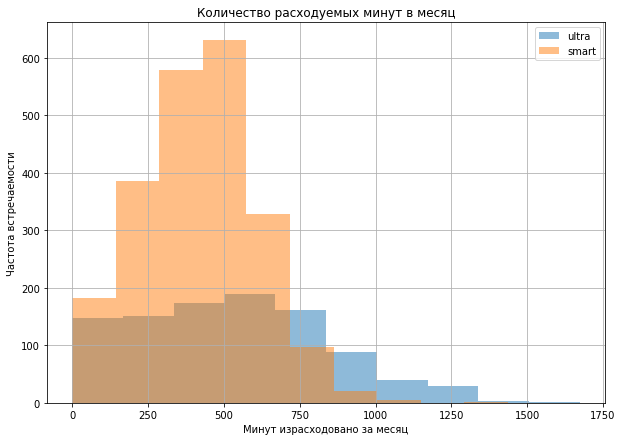

In [75]:
df_general.query('tariff == "ultra"')['sum_calls'].hist(figsize=(10 ,7), alpha=0.5)
df_general.query('tariff == "smart"')['sum_calls'].hist(figsize=(10 ,7), alpha=0.5)
plt.legend(['ultra', 'smart'])
plt.title('Количество расходуемых минут в месяц')
plt.xlabel('Минут израсходовано за месяц')
plt.ylabel('Частота встречаемости')
plt.show()

Обе диаграммы скошены влево. Пик значений для тарифа "Смарт" приходится на диапазон значений 450-550 мин, для тарифа "Ультра" - 500-650 мин. Среди абонентов тарифа "Ультра" значительно больше тех кто тратит в месяц 1000 и более минут, чем среди абонентов тарифа "Смарт".

### Анализ количества сообщений

In [57]:
analysis(df_general.query('tariff == "ultra"')['message_count']) 
#числовое описание данных по ежемесячно отправляемым сообщениям абонентами тарифа ultra

Числовое описание данных:
count   985.00
mean     49.36
std      47.80
min       0.00
25%       6.00
50%      38.00
75%      79.00
max     224.00
Name: message_count, dtype: float64
Дисперсия:
2282.95


In [58]:
analysis(df_general.query('tariff == "smart"')['message_count']) 
#числовое описание данных по ежемесячно отправляемым сообщениям абонентами тарифа smart

Числовое описание данных:
count   2,229.00
mean       33.38
std        28.23
min         0.00
25%        10.00
50%        28.00
75%        51.00
max       143.00
Name: message_count, dtype: float64
Дисперсия:
796.46


Среднее количество ежемесячно отправляемых сообщений абонентами тарифа "Ультра" существенно превышает таковое на тарифе "Смарт", 61,16 и 38,72 соответственно. При этом и в том, и в другом случае медиана ниже среднего значения и составляет 51 и 34 для тарифов "Ультра" и "Смарт" соответственно. Межквартильный интервал включает значения от 24 до 87,5 для тарифа "Ультра", и от 17 до 55 для тарифа "Смарт", максимальные значения составляют 224 и 143 сообщения соответственно. Как и в случае со звонками среди абонентов тарифа "Ультра" ни за один из месяцев не был превышен лимит сообщений предусмотренный тарифом, в то время как среди абонентов тарифа "Смарт", более чем в 25% случаев лимит был превышен.

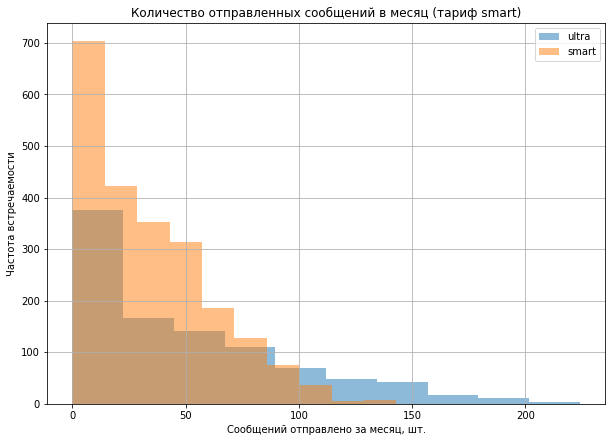

In [76]:
df_general.query('tariff == "ultra"')['message_count'].hist(grid=True, figsize=(10, 7), alpha=0.5)
df_general.query('tariff == "smart"')['message_count'].hist(grid=True, figsize=(10, 7), alpha=0.5)
plt.legend(['ultra', 'smart'])
plt.title('Количество отправленных сообщений в месяц (тариф smart)')
plt.xlabel('Сообщений отправлено за месяц, шт.')
plt.ylabel('Частота встречаемости')
plt.show()

В обоих случаях диаграммы скошены вправо, и пик значений приходится на диапазон от 0 до 25-30 сообщений в месяц. Среди абонентов тарифа "Ультра" существенно больше тех кто использует в месяц более 100 сообщений, чем среди, пользующихся тарифом "Смарт".

### Анализ интернет-трафика

In [60]:
analysis(df_general.query('tariff == "ultra"')['gb_used'])
#числовое описание данных по объему ежемесячно расходуемого интернет-трафика абонентами тарифа ultra

Числовое описание данных:
count   985.00
mean     19.49
std       9.85
min       0.00
25%      12.00
50%      19.00
75%      27.00
max      49.00
Name: gb_used, dtype: float64
Дисперсия:
96.99


In [61]:
analysis(df_general.query('tariff == "smart"')['gb_used'])
#числовое описание данных по объему ежемесячно расходуемого интернет-трафика абонентами тарифа smart

Числовое описание данных:
count   2,229.00
mean       16.33
std         5.75
min         0.00
25%        13.00
50%        17.00
75%        20.00
max        38.00
Name: gb_used, dtype: float64
Дисперсия:
33.01


Абоненты тарифа "Ультра" в среднем в месяц тратят 19,69 GB интернет-трафика, что практически равно медиане данного показателя (19 GB) и не выходит за рамки месячного лимита интернет-трафика. Абоненты тарифы "Смарт" в среднем расходуют за месяц немногим меньшее количество интернет трафика (16,34 GB), что также практически равно медиане данного показателя (17,00 GB), но при этом и среднее значение и медиана превышает лимит интернет-трафика, т.е. абоненты тарифа "Смарт" более, чем в 50% случаев превышают свой месячный лимит. Межквартильные интервалы включают значения от 12 до 27 и от 13 до 20 GB, а максимальное количество потраченных GB сотсавляет 49 и 38 для тарифов "Ультра" и "Смарт" соответственно. Стандартное отклонение и дисперсия значений на тарифе "Ультра" - 9,70  GB и 94,05 GB^2, для тарифа "Смарт" - 5,74 GB и 32,91 GB^2.  

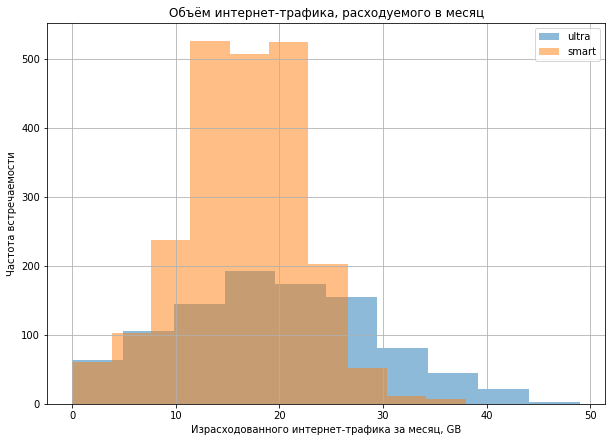

In [77]:
df_general.query('tariff == "ultra"')['gb_used'].hist(grid=True, figsize=(10, 7), alpha=0.5)
df_general.query('tariff == "smart"')['gb_used'].hist(grid=True, figsize=(10, 7), alpha=0.5)
plt.legend(['ultra', 'smart'])
plt.title('Объём интернет-трафика, расходуемого в месяц')
plt.xlabel('Израсходованного интернет-трафика за месяц, GB')
plt.ylabel('Частота встречаемости')
plt.show()

Распределений значений затрачиваемого ежемесячно интернет-трафика ближе всего к нормальному, по сравнению с предыдущими параметрами, пожалуй можно сказать, что оно практически нормальное. В случае с тарифом "Смарт" гистограмма несколько скошена влево, в то время как гистограмма распределения значений для тарифа "Ультра" немного скошена вправо. Подавляющее большинство значений на гистограмме тарифа "Смарт" приходится на диапазон 11-23 GB, тарифа "Ультра" - 15-29 GB. Абоненты тарифа "Ультра" гораздо чаще, чем абоненты тарифа "Смарт" тратят 30 и более GB интернет-трафика в месяц.

### Анализ платы за услуги связи

In [80]:
analysis(df_general.query('tariff == "ultra"')['month_revenue'])
#числовое описание данных по ежемесячной плате абонентов тарифа ultra

Числовое описание данных:
count     985.00
mean    2,070.15
std       376.19
min     1,950.00
25%     1,950.00
50%     1,950.00
75%     1,950.00
max     4,800.00
Name: month_revenue, dtype: float64
Дисперсия:
141373.07


Средняя ежемесячная плата абонентов тарифа "Ультра" составляет 2 070,15 руб, т.е. практически равна ежемесячной абонентской плате, т.к. 75% пользователей не превышает лимитов заложенных в тариф. Максимальный платеж составил 4 800,00 руб.

In [81]:
analysis(df_general.query('tariff == "smart"')['month_revenue'])
#числовое описание данных по ежемесячной плате абонентов тарифа smart

Числовое описание данных:
count   2,229.00
mean    1,289.97
std       818.40
min       550.00
25%       550.00
50%     1,023.00
75%     1,750.00
max     6,770.00
Name: month_revenue, dtype: float64
Дисперсия:
669485.22


Среди пользователей тарифа "Смарт" наблюдается обратная ситуация только 25% абонентов укладываются в установленные месячные лимиты, и соответственно их ежемесячная плата составляет 550,00 руб. Средняя ежемесячная плата составляет 1 289,97 руб и превышает медиану (1 023,00 руб), но и тот и другой показатель, ниже аналогичного для тарифа "Ультра". Максимальный платеж среди клиентов тарифа "Смарт", существенно превысил таковой среди клиентов тарифа "Ультра", и составил 6 770,00 руб.

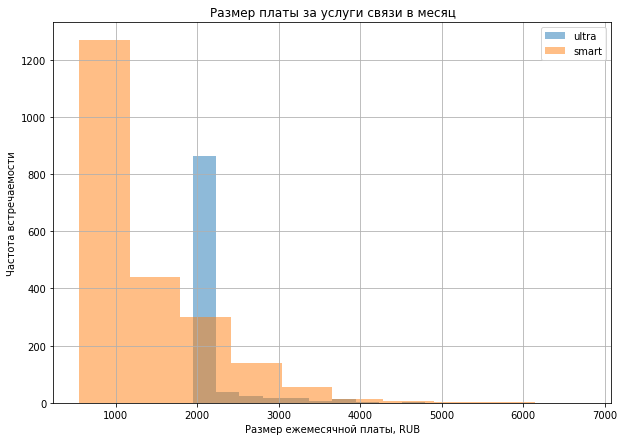

In [79]:
df_general.query('tariff == "ultra"')['month_revenue'].hist(grid=True, figsize=(10, 7), alpha=0.5)
df_general.query('tariff == "smart"')['month_revenue'].hist(grid=True, figsize=(10, 7), alpha=0.5)
plt.legend(['ultra', 'smart'])
plt.title('Размер платы за услуги связи в месяц')
plt.xlabel('Размер ежемесячной платы, RUB')
plt.ylabel('Частота встречаемости')
plt.show()

Обе гистограммы смещены в право, т.к. пики встречаемости значений концентрируются у значения равного ежемесячной абонентской плате. В случае с тарифом "Смарт" смещение вправо выражено сильнее, потому что, как было сказано ранее, абоненты этого тарифа гораздо чаще выходят за пределы установленного лимита, чем абоненты "Ультра". 

### Вывод

- Абоненты тарифа "Ультра" ожидаемо тратят в месяц в среднем большее количество минут, сообщений и гигабайт интернет-трафика, чем пользователи тарифа "Смарт".
- Абоненты тарифа "Ультра" превышают ежемесячный лимит только по интернет-трафику, в то время как более 25% абонентов тарифа "Смарт" превышают заданный месячный лимит по звонкам и сообщениям, и более 50% по интернет-трафику.
- Распределение значений количества ежемесячно расходуемых минут, сообщений и интренет-трафика среди абонентов разных тарифов, в целом имеет сходный характер: гистограммы распределения количества израсходованных минут и сообщений смещены влево; распределение затраченного интернет-трафика наиболее близко к нормальному, при этом для тарифа "Ультра" оно несколько смещено вправо, а для тарифа "Смарт" - влево.

## Проверка гипотез ##

### Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются?

Для ответа на поставленный выше вопрос, выдвинем нулевую и альтернативную гипотезы. Нулевая гипотеза должна содержать выражение равенства, поэтому сформулируем её следующим образом: "Средняя выручка пользователей тарифа 'Ультра' и 'Смарт' не различается (равна)". Следовательно альтернативная гипотеза гласит: "Средняя выручка пользователей тарифа 'Ультра' и 'Смарт' различается (больше или меньше)". Для проверки выдвинутых гипотез используем t-тест для не связанных совокупностей, так как генеральные совокупности не зависят друг от друга. Так как выборки разного размера установим параметр equal_var=False при вызове метода для проведения t-теста. Используем общепринятый критический уровень статистической значимости для проверки гипотезы равный 0.05:

In [69]:
alpha = 0.05 #критический уровень статистической значимости
results = st.ttest_ind(df_general.query('tariff == "ultra"')['month_revenue'].tolist(), 
                       df_general.query('tariff == "smart"')['month_revenue'].tolist(), equal_var=False)
print('Средняя выручка пользователей тарифа "Ультра": ', (df_general.query('tariff == "ultra"')['month_revenue'].mean()).round(2))
print('Средняя выручка пользователей тарифа "Смарт": ', (df_general.query('tariff == "smart"')['month_revenue'].mean()).round(2))
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

Средняя выручка пользователей тарифа "Ультра":  2070.15
Средняя выручка пользователей тарифа "Смарт":  1289.97
p-значение:  4.2606313931076085e-250
Нулевая гипотеза отвергнута


Нулевая гипотеза отвергнута, а значит средняя выручка пользователей тарифов "Ультра" и "Смарт" различается. В наших выборках средняя выручка пользователей тарифа "Ультра" выше.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов?

Ответ на данный вопрос получим аналогичным предыдущему способом. Нулевая гипотеза: "Средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других регионов", альтернативная гипотеза: "Средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов".

In [64]:
df_general.query('"Москва" in city')['user_id'].count() #количество наблюдением в выборке абонентов из Москвы

611

Количество наблюдений в выборках, как и в первом случае, сильно отличается, поэтому установим параметр equal_var=False.

In [65]:
alpha = 0.05 #критический уровень статистической значимости
results = st.ttest_ind(df_general.query('"Москва" in city')['month_revenue'].tolist(), 
                       df_general.query('"Москва" not in city')['month_revenue'].tolist(), equal_var=False)
print('Средняя выручка пользователей из Москвы: ', (df_general.query('"Москва" in city')['month_revenue'].mean()).round(2))
print('Средняя выручка пользователей из других регионов: ', (df_general.query('"Москва" not in city')['month_revenue'].mean()).round(2))
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

Средняя выручка пользователей из Москвы:  1546.71
Средняя выручка пользователей из других регионов:  1524.94
p-значение:  0.5257376663729298
Нельзя отвергнуть нулевую гипотезу


Нулевая гипотеза не может быть отвергнута, а значит средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других регионов.

## Общий вывод ##

При изучении датафреймов не было обнаружено дубликатов или требующих замены пропусков. В ходе предобработки и подготовки данных были изменены форматы данных в столбцах с датами, удалены лишние столбцы, произведены округления необходимых значений. Также были расчитаны помесячные значения длительности звонков, количества отправленных сообщений и использованного интернет-трафика, выручки для каждого пользователя.

По результатам анализа данных, выявлены следующие особенности:
- абоненты тарифа "Ультра" ожидаемо тратят в месяц в среднем большее количество минут, сообщений и гигабайт интернет-трафика, чем пользователи тарифа "Смарт";
- абоненты тарифа "Ультра" превышают ежемесячный лимит только по интернет-трафику, в то время как более 25% абонентов тарифа "Смарт" превышают заданный месячный лимит по звонкам и сообщениям, и более 50% по интернет-трафику;
- распределение значений количества ежемесячно расходуемых минут, сообщений и интренет-трафика среди абонентов разных тарифов, в целом имеет сходный характер: гистограммы распределения количества израсходованных минут и сообщений смещены влево; распределение затраченного интернет-трафика наиболее близко к нормальному, при этом для тарифа "Ультра" оно несколько смещено вправо, а для тарифа "Смарт" - влево.

Для проверки гипотез был использован t-тест для не связанных совокупностей. Результаты проверки гипотез:
- средняя выручка пользователей тарифов "Ультра" и "Смарт" различается, в представленных выборках она выше у пользователей тарифа "Ультра";
- средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других регионов.
